<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 53), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 107.55 KiB | 4.14 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 14:06:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'GBPUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 16.1MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 174kB 53.0MB/s 
     |████████████████████████████████| 143kB 52.3MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: znsj9bl4
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/znsj9bl4


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: 0vf3278s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 25s 127ms/step - loss: 0.2585 - mean_squared_error: 0.2585 - mean_absolute_error: 0.4279 - val_loss: 0.0964 - val_mean_squared_error: 0.0964 - val_mean_absolute_error: 0.2349
Epoch 2/100
16/16 [==============================] - 1s 69ms/step - loss: 0.1054 - mean_squared_error: 0.1054 - mean_absolute_error: 0.2553 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1652
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - mean_absolute_error: 0.2053 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1734
Epoch 4/100
16/16 [==============================] - 1s 64ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.2016 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1720
Epoch 5/100
16/16 [==============================] - 1s 63ms/step - loss: 0.0498 - mean_square

epoch,99
loss,0.00487
mean_squared_error,0.00487
mean_absolute_error,0.04927
val_loss,0.00259
val_mean_squared_error,0.00259
val_mean_absolute_error,0.04095
_runtime,140
_timestamp,1626185394
_step,99
best_val_loss,0.00258


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4f8fw0i9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 5s 123ms/step - loss: 0.1893 - mean_squared_error: 0.1893 - mean_absolute_error: 0.3227 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0599
Epoch 2/200
16/16 [==============================] - 1s 70ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0753 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0642
Epoch 3/200
16/16 [==============================] - 1s 66ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0559 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0406
Epoch 4/200
16/16 [==============================] - 1s 68ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0445 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0405
Epoch 5/200
16/16 [==============================] - 1s 67ms/step - loss: 0.0043 - mean_squared

epoch,168
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02501
val_loss,0.00138
val_mean_squared_error,0.00138
val_mean_absolute_error,0.02948
_runtime,197
_timestamp,1626185630
_step,168
best_val_loss,0.00134


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ju4s2yg6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 183ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2496 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0696
Epoch 2/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0992 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1347
Epoch 3/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1251 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0432
Epoch 4/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0795 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0422
Epoch 5/100
8/8 [==============================] - 1s 77ms/step - loss: 0.0130 - mean_squared_error: 0.

epoch,99
loss,0.00286
mean_squared_error,0.00286
mean_absolute_error,0.03997
val_loss,0.00157
val_mean_squared_error,0.00157
val_mean_absolute_error,0.03125
_runtime,68
_timestamp,1626185707
_step,99
best_val_loss,0.00157


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▂▂█▂▂▂▂▂▃▂▄▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▁▃▂▁▁▂▁▁
val_mean_squared_error,▆▂▂█▂▂▂▂▂▃▂▄▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▁▃▂▁▁▂▁▁
val_mean_absolute_error,▇▃▃█▃▂▃▂▂▃▂▅▂▂▃▃▂▁▁▁▂▁▁▁▁▂▂▂▂▂▂▃▁▃▂▂▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e1j3z0rx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 116ms/step - loss: 0.2427 - mean_squared_error: 0.2427 - mean_absolute_error: 0.4137 - val_loss: 0.0750 - val_mean_squared_error: 0.0750 - val_mean_absolute_error: 0.2139
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - mean_absolute_error: 0.2037 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0897
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.1009 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0961
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0863 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0788
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0080 - mean_squared_error: 0.0080 

epoch,34
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.03694
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04749
_runtime,13
_timestamp,1626185730
_step,34
best_val_loss,0.00338


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4szchuw2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 181ms/step - loss: 0.2608 - mean_squared_error: 0.2608 - mean_absolute_error: 0.4169 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1007
Epoch 2/50
8/8 [==============================] - 1s 80ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1165 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0893
Epoch 3/50
8/8 [==============================] - 1s 73ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0869 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0672
Epoch 4/50
8/8 [==============================] - 1s 67ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0721 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0573
Epoch 5/50
8/8 [==============================] - 1s 73ms/step - loss: 0.0069 - mean_squared_error: 0.0069 

epoch,49
loss,0.0027
mean_squared_error,0.0027
mean_absolute_error,0.03842
val_loss,0.00287
val_mean_squared_error,0.00287
val_mean_absolute_error,0.043
_runtime,38
_timestamp,1626185778
_step,49
best_val_loss,0.00287


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tqhqv2qs with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 186ms/step - loss: 0.1008 - mean_squared_error: 0.1008 - mean_absolute_error: 0.2405 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0703
Epoch 2/100
8/8 [==============================] - 1s 75ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1296 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0571
Epoch 3/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1093 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0484
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0928 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0460
Epoch 5/100
8/8 [==============================] - 1s 74ms/step - loss: 0.0156 - mean_squared_error: 0.

epoch,47
loss,0.00744
mean_squared_error,0.00744
mean_absolute_error,0.0607
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.04118
_runtime,38
_timestamp,1626185827
_step,47
best_val_loss,0.00257


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▁▃▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1f3i3u8j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 6s 126ms/step - loss: 0.1359 - mean_squared_error: 0.1359 - mean_absolute_error: 0.2893 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0905
Epoch 2/200
16/16 [==============================] - 1s 73ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0694 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0474
Epoch 3/200
16/16 [==============================] - 1s 72ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0423 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 4/200
16/16 [==============================] - 1s 69ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0389 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0462
Epoch 5/200
16/16 [==============================] - 1s 69ms/step - loss: 0.0026 - mean_squared

epoch,82
loss,0.00167
mean_squared_error,0.00167
mean_absolute_error,0.03022
val_loss,0.00179
val_mean_squared_error,0.00179
val_mean_absolute_error,0.03387
_runtime,106
_timestamp,1626185952
_step,82
best_val_loss,0.0017


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▂▂▁▁▁▃▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5cu18drl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 6s 99ms/step - loss: 0.1394 - mean_squared_error: 0.1394 - mean_absolute_error: 0.2873 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1093
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0972 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0614
Epoch 3/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0604 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0458
Epoch 4/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0503 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0462
Epoch 5/100
32/32 [==============================] - 2s 69ms/step - loss: 0.0047 - mean_squared_

epoch,99
loss,0.00185
mean_squared_error,0.00185
mean_absolute_error,0.03142
val_loss,0.00227
val_mean_squared_error,0.00227
val_mean_absolute_error,0.0383
_runtime,236
_timestamp,1626186240
_step,99
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: iyboamfj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 34ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1475 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0878
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0611 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0623
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0689 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0935
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0556 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0522
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error

epoch,49
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02348
val_loss,0.00135
val_mean_squared_error,0.00135
val_mean_absolute_error,0.02857
_runtime,26
_timestamp,1626186311
_step,49
best_val_loss,0.00129


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▃▃▃▃▂▂▃▃▂▂▂▂▁▂▂▂▁▂▂▂▂▁▂▁▁▂▁▂▂▁▁▁▁▁▁
val_loss,█▄█▃▂▂▁▁▂▁▂▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▄█▃▂▂▁▁▂▁▂▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅█▄▂▂▁▁▂▁▂▁▁▁▂▂▁▁▄▁▁▂▁▂▁▁▁▁▁▂▂▁▂▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p6cr2tvy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 120ms/step - loss: 0.3326 - mean_squared_error: 0.3326 - mean_absolute_error: 0.4828 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - val_mean_absolute_error: 0.3377
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1998 - mean_squared_error: 0.1998 - mean_absolute_error: 0.3588 - val_loss: 0.0769 - val_mean_squared_error: 0.0769 - val_mean_absolute_error: 0.2127
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0924 - mean_squared_error: 0.0924 - mean_absolute_error: 0.2334 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1261
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1670 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1013
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0319 - mean_squared_error: 0.0319 

epoch,49
loss,0.00822
mean_squared_error,0.00822
mean_absolute_error,0.06461
val_loss,0.00304
val_mean_squared_error,0.00304
val_mean_absolute_error,0.04436
_runtime,16
_timestamp,1626186359
_step,49
best_val_loss,0.00303


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nadautkx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 5s 241ms/step - loss: 0.1698 - mean_squared_error: 0.1698 - mean_absolute_error: 0.3313 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.2106
Epoch 2/50
8/8 [==============================] - 1s 70ms/step - loss: 0.0579 - mean_squared_error: 0.0579 - mean_absolute_error: 0.2032 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1272
Epoch 3/50
8/8 [==============================] - 1s 75ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1251 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0818
Epoch 4/50
8/8 [==============================] - 1s 77ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1012 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0713
Epoch 5/50
8/8 [==============================] - 1s 76ms/step - loss: 0.0092 - mean_squared_error: 0.0092 

epoch,48
loss,0.00285
mean_squared_error,0.00285
mean_absolute_error,0.04005
val_loss,0.00264
val_mean_squared_error,0.00264
val_mean_absolute_error,0.04149
_runtime,38
_timestamp,1626186411
_step,48
best_val_loss,0.00264


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ie29uel5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 6s 97ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - mean_absolute_error: 0.2993 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0743
Epoch 2/200
32/32 [==============================] - 2s 70ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0927 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0430
Epoch 3/200
32/32 [==============================] - 2s 70ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0780 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0441
Epoch 4/200
32/32 [==============================] - 2s 69ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0670 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 5/200
32/32 [==============================] - 2s 71ms/step - loss: 0.0081 - mean_squared_

epoch,89
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.03709
val_loss,0.00221
val_mean_squared_error,0.00221
val_mean_absolute_error,0.03778
_runtime,214
_timestamp,1626186636
_step,89
best_val_loss,0.0021


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▃▂▂▂▁▂▂▂▃▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▃▂▂▂▁▂▂▂▃▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▃▂▃▃▂▃▂▂▂▃▂▃▂▂▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 77x9hl1w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 121ms/step - loss: 0.1147 - mean_squared_error: 0.1147 - mean_absolute_error: 0.2514 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0947
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0878 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0422
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0593 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0568
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0540 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0

epoch,14
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.03105
val_loss,0.00251
val_mean_squared_error,0.00251
val_mean_absolute_error,0.03973
_runtime,11
_timestamp,1626186659
_step,14
best_val_loss,0.0023


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▃▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▅▅▅▅▅▅▅▅▅▅██
_timestamp,▁▁▁▅▅▅▅▅▅▅▅▅▅██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: h2kum113 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 7s 99ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - mean_absolute_error: 0.2036 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0460
Epoch 2/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0718 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1213
Epoch 3/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0787 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0474
Epoch 4/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0759 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0494
Epoch 5/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0077 - mean_squared_

epoch,10
loss,0.00513
mean_squared_error,0.00513
mean_absolute_error,0.05398
val_loss,0.00359
val_mean_squared_error,0.00359
val_mean_absolute_error,0.04829
_runtime,35
_timestamp,1626186707
_step,10
best_val_loss,0.00325


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▁▂▁▁
val_loss,▁█▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁█▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▃▄▄▅▆▆▇█
_timestamp,▁▂▂▃▄▄▅▆▆▇█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: xrx2ocgl with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 191ms/step - loss: 0.2416 - mean_squared_error: 0.2416 - mean_absolute_error: 0.3982 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0908
Epoch 2/50
8/8 [==============================] - 1s 75ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0993 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0874
Epoch 3/50
8/8 [==============================] - 1s 70ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0815 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0625
Epoch 4/50
8/8 [==============================] - 1s 79ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0616 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0566
Epoch 5/50
8/8 [==============================] - 1s 71ms/step - loss: 0.0049 - mean_squared_error: 0.0049 

epoch,49
loss,0.002
mean_squared_error,0.002
mean_absolute_error,0.03326
val_loss,0.00276
val_mean_squared_error,0.00276
val_mean_absolute_error,0.04165
_runtime,41
_timestamp,1626186759
_step,49
best_val_loss,0.00247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j9l7837t with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 191ms/step - loss: 0.2052 - mean_squared_error: 0.2052 - mean_absolute_error: 0.3358 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1313
Epoch 2/50
8/8 [==============================] - 1s 73ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1334 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 3/50
8/8 [==============================] - 1s 78ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0874 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0536
Epoch 4/50
8/8 [==============================] - 1s 75ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0768 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0399
Epoch 5/50
8/8 [==============================] - 1s 79ms/step - loss: 0.0093 - mean_squared_error: 0.0093 

epoch,16
loss,0.00575
mean_squared_error,0.00575
mean_absolute_error,0.0543
val_loss,0.00232
val_mean_squared_error,0.00232
val_mean_absolute_error,0.03864
_runtime,19
_timestamp,1626186790
_step,16
best_val_loss,0.00211


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▃▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▂▂▂▃▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: ountqic1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 4s 60ms/step - loss: 0.2560 - mean_squared_error: 0.2560 - mean_absolute_error: 0.4212 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - val_mean_absolute_error: 0.2364
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1126 - mean_squared_error: 0.1126 - mean_absolute_error: 0.2724 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1721
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.2147 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1841
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - mean_absolute_error: 0.2126 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1806
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0554 - mean_squared_

epoch,99
loss,0.00453
mean_squared_error,0.00453
mean_absolute_error,0.04822
val_loss,0.00265
val_mean_squared_error,0.00265
val_mean_absolute_error,0.04134
_runtime,28
_timestamp,1626186840
_step,99
best_val_loss,0.00264


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ksl8wi1j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.1130 - mean_squared_error: 0.1130 - mean_absolute_error: 0.2544 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0685
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0709 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0467
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0407 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0440
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_err

epoch,99
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02588
val_loss,0.00156
val_mean_squared_error,0.00156
val_mean_absolute_error,0.0316
_runtime,41
_timestamp,1626186894
_step,99
best_val_loss,0.00156


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nbq9a25c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 64ms/step - loss: 0.1589 - mean_squared_error: 0.1589 - mean_absolute_error: 0.3231 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1054
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1272 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0785
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1064 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0632
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0883 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0525
Epoch 5/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0123 - mean_squared_

epoch,26
loss,0.00624
mean_squared_error,0.00624
mean_absolute_error,0.05609
val_loss,0.00302
val_mean_squared_error,0.00302
val_mean_absolute_error,0.04407
_runtime,16
_timestamp,1626186922
_step,26
best_val_loss,0.00287


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: pfn6h7jz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 5s 213ms/step - loss: 0.3331 - mean_squared_error: 0.3331 - mean_absolute_error: 0.4784 - val_loss: 0.0987 - val_mean_squared_error: 0.0987 - val_mean_absolute_error: 0.2365
Epoch 2/200
8/8 [==============================] - 1s 81ms/step - loss: 0.1216 - mean_squared_error: 0.1216 - mean_absolute_error: 0.2774 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1829
Epoch 3/200
8/8 [==============================] - 1s 80ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.2089 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.2095
Epoch 4/200
8/8 [==============================] - 1s 77ms/step - loss: 0.0612 - mean_squared_error: 0.0612 - mean_absolute_error: 0.2087 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1777
Epoch 5/200
8/8 [==============================] - 1s 82ms/step - loss: 0.0437 - mean_squared_error: 0.

epoch,199
loss,0.00419
mean_squared_error,0.00419
mean_absolute_error,0.04881
val_loss,0.00289
val_mean_squared_error,0.00289
val_mean_absolute_error,0.04356
_runtime,139
_timestamp,1626187074
_step,199
best_val_loss,0.00288


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a64dnwmg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 5s 200ms/step - loss: 0.2868 - mean_squared_error: 0.2868 - mean_absolute_error: 0.4567 - val_loss: 0.1467 - val_mean_squared_error: 0.1467 - val_mean_absolute_error: 0.3069
Epoch 2/50
8/8 [==============================] - 1s 75ms/step - loss: 0.1689 - mean_squared_error: 0.1689 - mean_absolute_error: 0.3275 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.1888
Epoch 3/50
8/8 [==============================] - 1s 74ms/step - loss: 0.0792 - mean_squared_error: 0.0792 - mean_absolute_error: 0.2300 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1530
Epoch 4/50
8/8 [==============================] - 1s 74ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1900 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1636
Epoch 5/50
8/8 [==============================] - 1s 75ms/step - loss: 0.0461 - mean_squared_error: 0.0461 

epoch,49
loss,0.00504
mean_squared_error,0.00504
mean_absolute_error,0.05052
val_loss,0.00337
val_mean_squared_error,0.00337
val_mean_absolute_error,0.04703
_runtime,43
_timestamp,1626187130
_step,49
best_val_loss,0.00337


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lli5m95a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 123ms/step - loss: 0.2496 - mean_squared_error: 0.2496 - mean_absolute_error: 0.4110 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1465
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1411 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0938
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0854 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0725
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0685 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0603
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0047 - mean_squared_error: 0.

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 50,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 100,
        'hidden_size': 100,
        'learning_rate': 0.005,
        'optimizer': 'Nadam',
        'activation': 'tanh',
    }

In [16]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=100, return_sequences=True, input_shape=(window_len, 1), activation='tanh'))
model.add(Dropout(0.2))
# hidden layer
model.add(GRU(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Nadam(learning_rate=0.005)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  91601


In [17]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
40/40 [==============================] - 4s 6ms/step - loss: 0.0476
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 5/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 8/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 9/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 10/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 11/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 12/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 13/50
40/40 [==============================

In [18]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

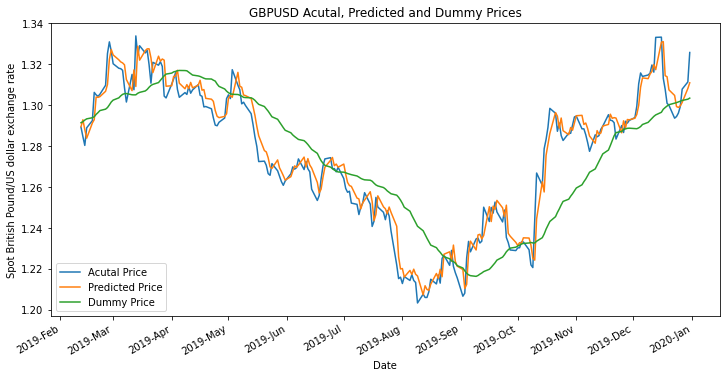

In [19]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

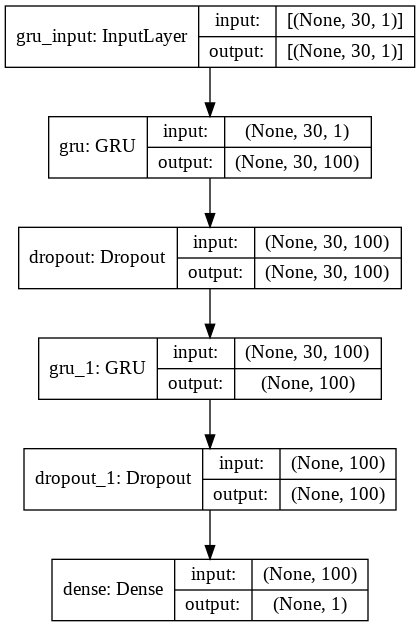

In [20]:
plot_model(model, show_shapes=True, expand_nested=True)

In [21]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0029093731890651106
RMSE:  0.05393860573897986
MAE:  0.041625422901083085


In [22]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_GBPUSD/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_GBPUSD/assets
